In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df_wsb = pd.read_csv('./csv_files/wsb_data.csv')
df_wsb_test = pd.read_csv('./csv_files/wsb_data_test.csv')
df_sm = pd.read_csv('./csv_files/sm_data.csv')
df_sm_test = pd.read_csv('./csv_files/sm_data_test.csv')

In [3]:
df = pd.concat([df_wsb,df_sm], axis = 0)
df_test = pd.concat([df_wsb_test,df_sm_test],axis = 0)

In [4]:
df.drop(columns='Unnamed: 0',inplace= True)
df_test.drop(columns='Unnamed: 0',inplace= True)

In [5]:
df.isnull().sum()

subreddit         0
selftext       4645
title             0
created_utc       0
dtype: int64

In [6]:
df_test.isnull().sum()

subreddit        0
selftext       376
title            0
created_utc      0
dtype: int64

In [7]:
df.fillna('',inplace = True)
df_test.fillna('',inplace = True)

In [8]:
df['subreddit'].value_counts()

wallstreetbets    4000
StockMarket       4000
Name: subreddit, dtype: int64

In [9]:
df['subreddit'] = df['subreddit'].map({'wallstreetbets': 1, 'StockMarket': 0 })
df_test['subreddit'] = df_test['subreddit'].map({'wallstreetbets': 1, 'StockMarket': 0 })

In [10]:
df['subreddit'].value_counts()

1    4000
0    4000
Name: subreddit, dtype: int64

In [11]:
X= df['title']
y = df['subreddit']



In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

In [13]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,random_state = 42)

# Modelling 

# Xgboost Model, default parameters

Creating a default xgboost to get a baseline of the score using xgboost

In [ ]:
pipe_xgb = Pipeline([
    ('cvec', CountVectorizer()),
    ('xgb', xgb.XGBClassifier())
])

In [ ]:
pipe_xgb.fit(X_train,y_train)

In [ ]:
print(pipe_xgb.score(X_train,y_train))
pipe_xgb.score(X_test,y_test)

Models Overfit using the default parameters but it predicts the right subreddit 73% of the time, 23% higher than the baseline.

# XgBoost Model with hyperparameter tuning

In [14]:
import xgboost as xgb

In [ ]:
pipe_xgb = Pipeline([
    ('cvec', CountVectorizer()),
    ('xgb', xgb.XGBClassifier())
])
pipe_params = {
    'xgb__learning_rate':[0.3,1.0],
    'xgb__max_depth':[3,7],
    'xgb__base_score':[0.3,0.7],
    'xgb__random_state': [42],
    'cvec__max_features': [2000,8000],
    'cvec__stop_words':[None,'english'],
    'cvec__ngram_range':[(1,1),(2,2),(3,3)],
    'cvec__min_df':[1,2],
    'cvec__max_df':[0.5,0.9]
}

In [ ]:
gs_xgb = GridSearchCV(
    pipe_xgb,
    param_grid = pipe_params,
    cv = 3
)

In [ ]:
gs_xgb.fit(X_train,y_train)

In [ ]:
gs_xgb.best_params_

In [ ]:
gs_xgb.score(X_test,y_test)

The score with the given parameters was only 0.02% better than the default parameters, but utilizing
best_params I can see how to adjust the parameters more.

In [ ]:
pipe_xgb_2 = Pipeline([
    ('cvec', CountVectorizer()),
    ('xgb', xgb.XGBClassifier())
])
pipe_params_2 = {
    'xgb__learning_rate':[0.1,0.3,0.5],
    'xgb__max_depth':[7],
    'xgb__base_score':[0.1,0.3,0.5],
    'xgb__random_state': [42],
    'xgb__tree_method':['hist','gpu_hist'],
    'xgb__n_estimators':[50,100],
    'xgb__min_child_weight':[1,2],
    'xgb__colsample_bytree':[0.3,0.6],
    'cvec__max_features': [1000,1500,2000],
    'cvec__stop_words':[None,'english'],
    'cvec__ngram_range':[(1,1),(2,2),(3,3)]
}

In [ ]:
gs_xgb_2 = GridSearchCV(
    pipe_xgb_2,
    param_grid=pipe_params_2,
    cv = 3

)

In [ ]:
gs_xgb_2.fit(X_train,y_train)

In [ ]:
gs_xgb_2.best_params_

In [ ]:
gs_xgb_2.score(X_train,y_train)

In [ ]:
gs_xgb_2.score(X_test,y_test)

# XGB with Random Search

In [15]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

In [16]:
pipe_rs_xgb = Pipeline([
    ('cvec', CountVectorizer()),
    ('xgb', xgb.XGBClassifier())
])
rs_params = {
    'xgb__learning_rate':[0.1,0.3,0.5],
    'xgb__max_depth': list(np.arange(0,100,step = 10)),
    'xgb__base_score':[0.1,0.3,0.5],
    'xgb__random_state': [42],
    'xgb__tree_method':['hist','gpu_hist'],
    'xgb__n_estimators': list(np.arange(10,500, step = 50)),
    'cvec__max_features':randint(1000,10000),
    'cvec__stop_words':[None,'english'],
    'cvec__ngram_range':[(1,1),(2,2),(3,3)]
}

In [17]:
rs_xgb = RandomizedSearchCV(
    pipe_rs_xgb,
    param_distributions = rs_params,
    n_iter = 500
)

In [18]:
rs_xgb.fit(X_train,y_train)

/Users/jaysonv/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
1285 fits failed out of a total of 2500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jaysonv/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jaysonv/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/jaysonv/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/xgboost/core.

RandomizedSearchCV(estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                             ('xgb',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric=None,
                                                            feature_types=None,
                                                            gamm

In [ ]:
rs_xgb.best_params_

In [ ]:
rs_xgb.score(X_train,y_train)

In [ ]:
rs_xgb.score(X_test,y_test)

# Random Forest Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier


In [ ]:
pipe_rf = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])
pipe_rf_params = {
    'cvec__max_features':randint(1000,10000),
    'cvec__stop_words':[None,'english'],
    'cvec__ngram_range':[(1,1),(2,2),(3,3)],
    'cvec__min_df':randint(1,4),
    'cvec__max_df':[0.5,0.7,0.9],
    'rf__n_estimators':list(np.arange(10,500, step = 50)),
    'rf__max_depth':list(np.arange(0,100,step = 10)),
    'rf__min_samples_split':np.arange(2,10,step = 2),
    'rf__min_samples_leaf':randint(1,10)
}

In [ ]:
rs_rf = RandomizedSearchCV(
    pipe_rf,
    param_distributions= pipe_rf_params,
    cv=3
    
)

In [ ]:
rs_rf.fit(X_train,y_train)

In [ ]:
rs_rf.score(X_test,y_test)

# GridSearched Bagging

In [28]:
from sklearn.ensemble import BaggingClassifier

In [ ]:
pipe_bag = Pipeline([
    ('cvec',CountVectorizer()),
    ('bag', BaggingClassifier())
])

In [ ]:
pipe_bag_params = {
    'cvec__max_features': [500,1000],
    'cvec__stop_words':[None],
    'cvec__ngram_range':[(1,1),(2,2)],
    'bag__n_estimators':[100,150],
    'bag__max_samples':[0.7,0.9],
    'bag__random_state':[42,123],
    'bag__max_features':[500,1000]  
}

In [ ]:
gs_bag = GridSearchCV(
    pipe_bag,
    pipe_bag_params,
    cv=3
)

In [ ]:
gs_bag.fit(X_train,y_train)

In [ ]:
gs_bag.best_params_

In [ ]:
print(gs_bag.score(X_train,y_train))
print(gs_bag.score(X_test,y_test))
print(gs_bag.score(test_X,test_y))

# RandomSearched Bagging

In [32]:
pipe_rs_bag = Pipeline([
    ('cvec',CountVectorizer()),
    ('bag',BaggingClassifier())
])
pipe_rs_bag_params = {
    'cvec__stop_words':[None],
    'cvec__ngram_range':[(1,1),(3,3)],
    'cvec__min_df':randint(1,10),
    'cvec__max_df':[0.5,0.7,0.9],
    'bag__n_estimators':list(np.arange(100,10000, step = 100)),
    'bag__max_samples':[0.7,0.9],
    'bag__random_state':[42,123],
    'bag__max_features':list(np.arange(100,5000, step = 100)) 
}

In [33]:
rs_bag = RandomizedSearchCV(
    pipe_rs_bag,
    param_distributions = pipe_rs_bag_params,
    cv = 3
)

In [34]:
rs_bag.fit(X_train,y_train)

/Users/jaysonv/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
21 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jaysonv/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jaysonv/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/jaysonv/opt/anaconda3/envs/dsi/lib/python3.8/site-packages/sklearn/ensemble

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                             ('bag', BaggingClassifier())]),
                   param_distributions={'bag__max_features': [100, 200, 300,
                                                              400, 500, 600,
                                                              700, 800, 900,
                                                              1000, 1100, 1200,
                                                              1300, 1400, 1500,
                                                              1600, 1700, 1800,
                                                              1900, 2000, 2100,
                                                              2200, 2300, 2400,
                                                              2500, 2600, 2700,
                                                              2800, 2900, 3000, ...],
                           

In [ ]:
rs_bag.best_params_

In [ ]:
print(rs_bag.score(X_train,y_train))
print(rs_bag.score(X_test,y_test))

# KNN


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
pipe_knn = Pipeline([
    ('cvec', CountVectorizer()),
    ('knn',KNeighborsClassifier())
])
pipe_knn_params = {
    'cvec__max_features': [500,1000],
    'cvec__stop_words':[None],
    'cvec__ngram_range':[(1,1),(3,3)],
    'cvec__min_df':[1,2,3],
    'cvec__max_df':[0.5,0.7,0.9],
    'knn__n_neighbors': [1,3,5],
    'knn__p':[2,3,4],
    'knn__weights':['uniform','distance',None]
}
gs_knn = GridSearchCV(
    pipe_knn,
    param_grid = pipe_knn_params,
    cv = 3
)

In [ ]:
gs_knn.fit(X_train,y_train)

In [ ]:
gs_knn.best_params_

In [ ]:
print(gs_knn.score(X_train,y_train))
print(gs_knn.score(X_test,y_test))
print(gs_knn.score(test_X,test_y))

# Logistic Regression 

In [ ]:
pipe_lr = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])
pipe_lr_params= {
    'cvec__max_features':randint(1000,10000),
    'cvec__stop_words':[None,],
    'cvec__ngram_range':[(1,1),(2,2),(3,3)],
    'cvec__min_df':randint(1,4),
    'cvec__max_df':[0.5,0.7,0.9],
    'lr__penalty':['l2','l1','elasticnet'],
    'lr__C':[0.3,0.5,0.7,0.9],
    'lr__max_iter':randint(100,1000)
}

In [ ]:
rs_lr = RandomizedSearchCV(
    pipe_lr,
    param_distributions = pipe_lr_params,
    cv = 3
)

In [ ]:
rs_lr.fit(X_train,y_train)

In [ ]:
rs_lr.best_params_

In [ ]:
rs_lr.score(X_train,y_train)
rs_lr.score(X_test,y_test)

# Applying model to "original" data

In [19]:
test_X = df_test['title']
test_y = df_test['subreddit']

In [20]:
print(rs_xgb.score(X_train,y_train))
print(rs_xgb.score(X_test,y_test))
print(rs_lr.score(X_train,y_train))
print(rs_lr.score(X_test,y_test))

0.868
0.7445


NameError: name 'rs_lr' is not defined

In [21]:
print(f'RandomSearched XgBoost: {rs_xgb.score(test_X,test_y)}')
print(f'GridSearched XgBoost: {gs_xgb_2.score(test_X,test_y)}')
print(f'RandomSearched Logisitic Regression: {rs_lr.score(test_X,test_y)}')
print(f'GridSearched Bagging: {round(gs_bag.score(test_X,test_y),2)}')
print(f'RandomSearched Bagging: {rs_bag.score(test_X,test_y)}')
print(f'GridSearched KNN: {round(gs_knn.score(test_X,test_y),2)}')



RandomSearched XgBoost: 0.6616666666666666


NameError: name 'gs_xgb_2' is not defined

In [22]:
print(f'RandomSearched XgBoost: {rs_xgb.score(test_X,test_y)}')
print(f'RandomSearched Bagging: {rs_bag.score(test_X,test_y)}')

RandomSearched XgBoost: 0.6616666666666666


NameError: name 'rs_bag' is not defined

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [24]:
preds = rs_xgb.predict(test_X)

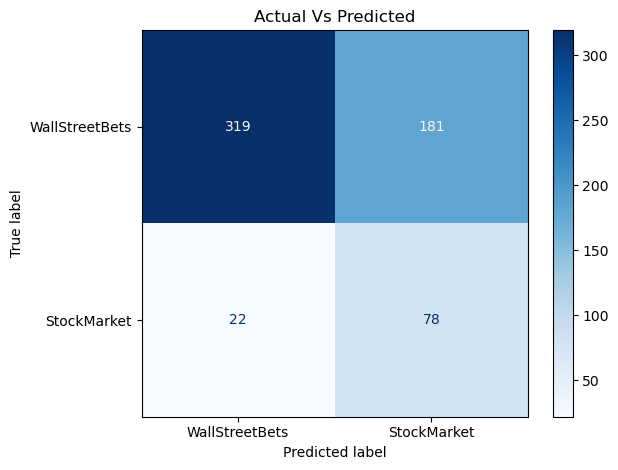

In [26]:
cm= confusion_matrix(test_y,preds,labels= rs_xgb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm,display_labels = ['WallStreetBets','StockMarket'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Actual Vs Predicted')
plt.tight_layout()
plt.savefig('./images/ConfusionMatrix')